### 💻 Importación de librerías y módulos personalizados

Se importan todas las librerías necesarias para el análisis, visualización, modelado y evaluación. 

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import importlib.util

# Obtener la ruta absoluta del directorio actual
current_dir = os.getcwd()
print(f"Directorio actual: {current_dir}")

# Rutas a los archivos
src_path = os.path.join(current_dir, "..", "src")
preprocessing_path = os.path.join(src_path, "preprocessing.py")
eda_path = os.path.join(src_path, "eda.py")
modeling_path = os.path.join(src_path, "modeling.py")
predict_path = os.path.join(src_path, "predict.py")

# Cargar los módulos dinámicamente
# Preprocessing
spec = importlib.util.spec_from_file_location("preprocessing", preprocessing_path)
preprocessing = importlib.util.module_from_spec(spec)
spec.loader.exec_module(preprocessing)
Preprocessing = preprocessing.Preprocessing

# EDA
spec = importlib.util.spec_from_file_location("eda", eda_path)
eda = importlib.util.module_from_spec(spec)
spec.loader.exec_module(eda)
EDA = eda.EDA

# Modeling
spec = importlib.util.spec_from_file_location("modeling", modeling_path)
modeling_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modeling_module)
Modeling = modeling_module.Modeling  # Importamos la clase Modeling

# Predict
spec = importlib.util.spec_from_file_location("predict", predict_path)
predict_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(predict_module)
predict_new = predict_module.predict_new  # Importamos la función predict_new

Directorio actual: c:\Users\alex_\PROYECTOS\Master_AI\Evaluacion-ML-ClimaBilbao\notebooks


### 🧼 Preprocesamiento inicial de los datos

Se carga el dataset horario de Bilbao, se eliminan las columnas irrelevantes y se transforma la variable de precipitación (`prcp`) en una variable binaria `rain`, que indica si ha llovido (`1`) o no (`0`).  
Además, se extraen características temporales (`día`, `mes`, `hora`, etc.) útiles para el modelado.



In [38]:
# Cargar datos
df = pd.read_csv('../data/bilbao_horario_2000_2024.csv', parse_dates=['time'])

# Crear objeto de preprocesamiento
pp = Preprocessing(df)

# Eliminar columnas sin utilidad
pp.drop_columns(['snow', 'tsun', 'wpgt', 'coco','dwpt'])

# Rellenar nulos de precipitación con 0
pp.fillna_value('prcp', 0)

# Crear variable binaria 'rain'
pp.create_rain_column()

# Imputar temperatura media con la media diaria
pp.fillna_with_daily_mean('temp')

# Separar columna 'time' en 'fecha' y 'hora'
pp.split_column('time')

pp.extract_date_features('time')

# Obtener datos finales
df_clean = pp.get_data()

Columnas eliminadas: ['snow', 'tsun', 'wpgt', 'coco', 'dwpt']
Nulos en 'prcp' rellenados con: 0
Columna 'rain' creada a partir de 'prcp' con umbral 0.1 mm.
Nulos en 'temp' rellenados con la media diaria.
Columna 'time' dividida en 'fecha' y 'hora' (datetime).
✔ Variables temporales extraídas: hour, month, weekday, day, dayofyear


In [76]:
df.head(5)

,time,temp,rhum,prcp,wdir,wspd,pres,rain,fecha,hora,day,month,year
0,2000-01-01 04:00:00,7.0,93.0,0.0,110.0,5.4,NaN,0,2000-01-01,4,1,1,2000
1,2000-01-01 05:00:00,6.0,100.0,0.0,NaN,0.0,NaN,0,2000-01-01,5,1,1,2000
2,2000-01-01 06:00:00,6.3,92.0,0.0,NaN,0.0,1029.2,0,2000-01-01,6,1,1,2000
3,2000-01-01 07:00:00,6.0,100.0,0.0,120.0,3.6,NaN,0,2000-01-01,7,1,1,2000
4,2000-01-01 08:00:00,6.0,100.0,0.0,80.0,1.8,NaN,0,2000-01-01,8,1,1,2000


### 🔍 Análisis exploratorio de datos (EDA)

Se analizan las variables principales del dataset (`temp`, `rhum`, `wspd`, `pres`) a través de distribuciones, boxplots por clase (`rain`) y matriz de correlación, para entender sus patrones y relaciones con la variable objetivo.



📋 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219141 entries, 0 to 219140
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    219141 non-null  datetime64[ns]
 1   temp    219141 non-null  float64       
 2   rhum    194015 non-null  float64       
 3   prcp    219141 non-null  float64       
 4   wdir    165537 non-null  float64       
 5   wspd    193878 non-null  float64       
 6   pres    118479 non-null  float64       
 7   rain    219141 non-null  int64         
 8   fecha   219141 non-null  object        
 9   hora    219141 non-null  int32         
 10  day     219141 non-null  int32         
 11  month   219141 non-null  int32         
 12  year    219141 non-null  int32         
dtypes: datetime64[ns](1), float64(6), int32(4), int64(1), object(1)
memory usage: 18.4+ MB
None

📊 Estadísticas descriptivas:
                      time           temp           

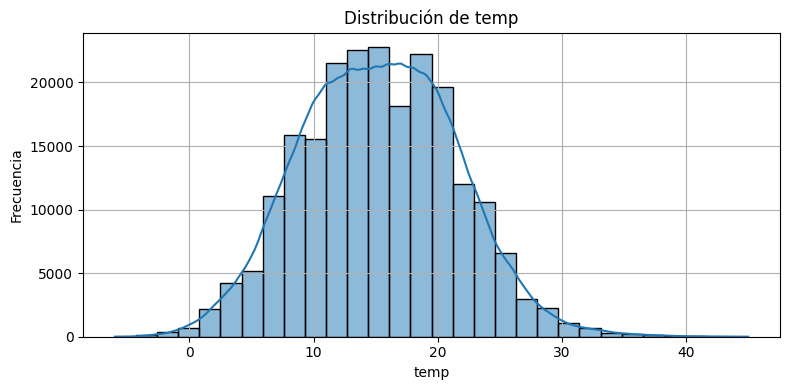

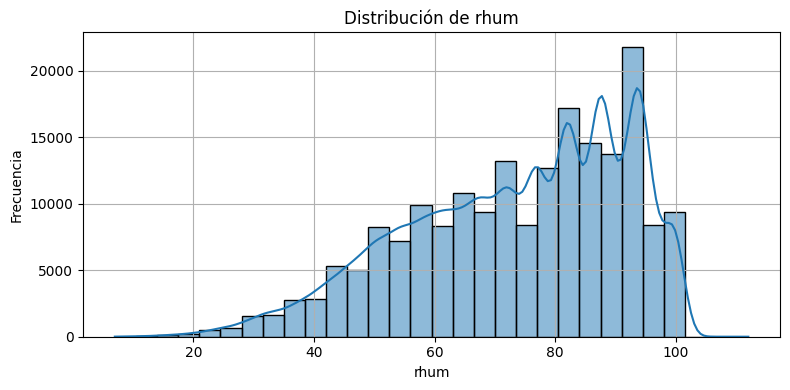

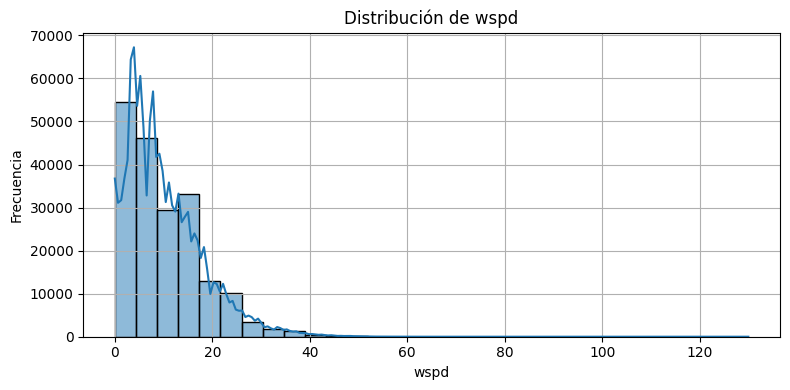

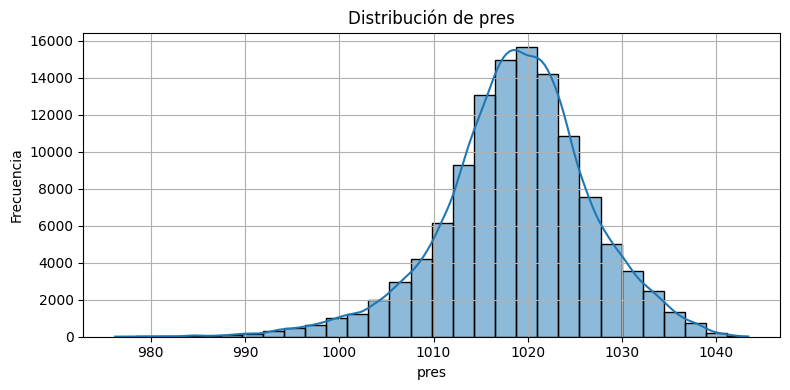

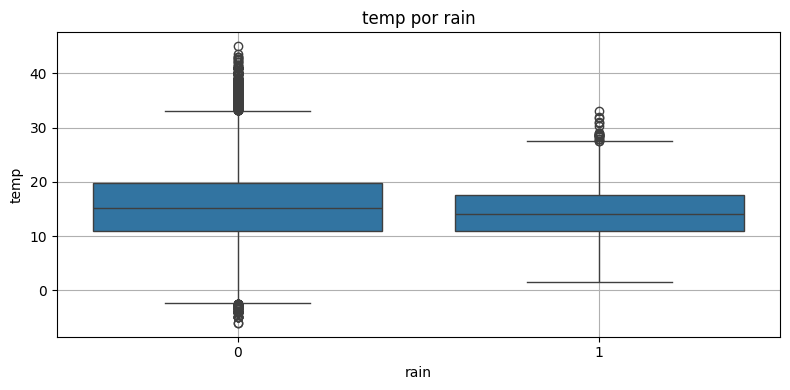

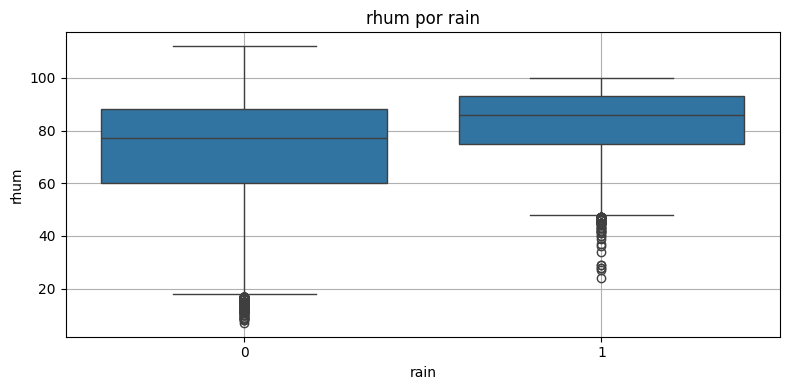

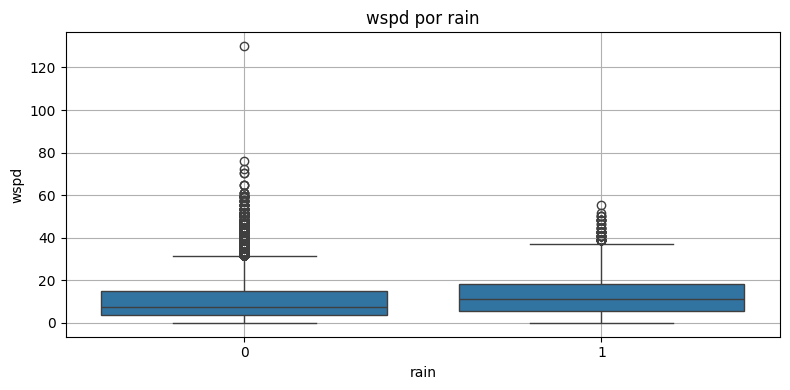

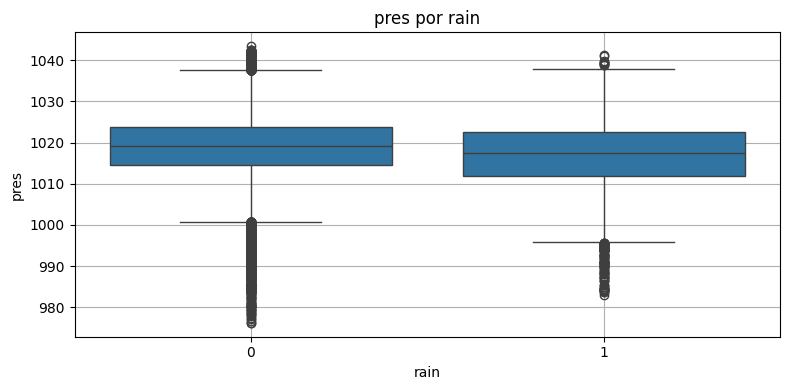

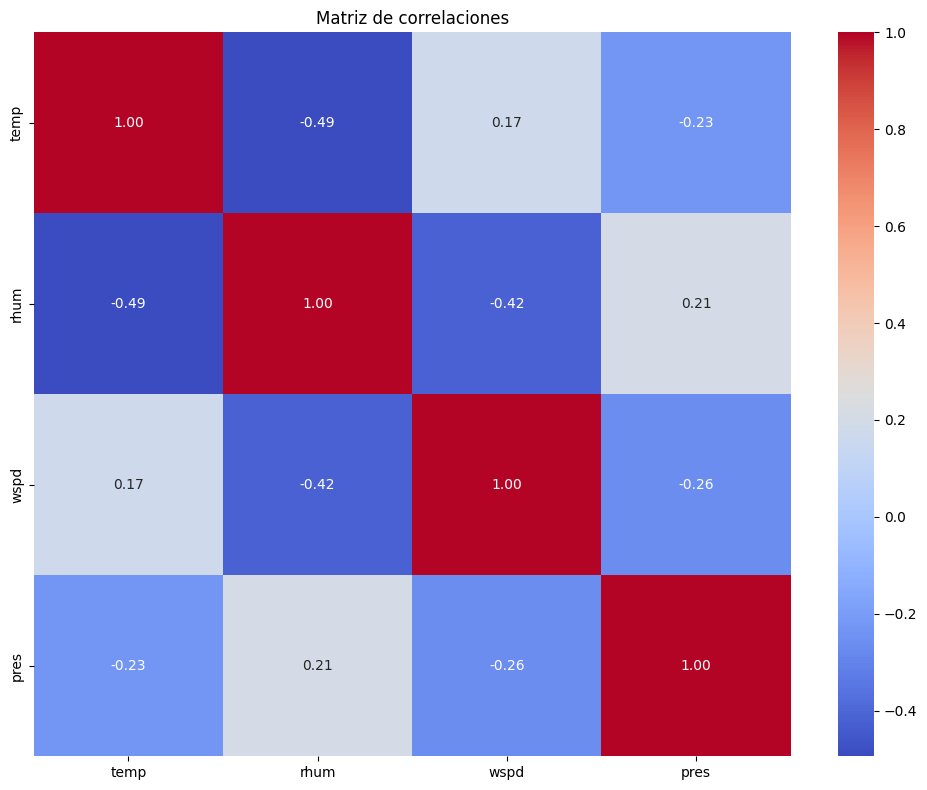

In [40]:
eda = EDA(df)

# Análisis general
eda.explore()

# Variables numéricas
num_features = ['temp', 'rhum', 'wspd', 'pres']

# Distribuciones
eda.plot_distributions(num_features)

# Boxplots por lluvia
eda.plot_boxplots(num_features, target='rain')

# Matriz de correlación
eda.plot_correlation_matrix(num_features)



### ⚖️ Balance de clases

Se visualiza la proporción de clases (`rain = 0` y `rain = 1`) en el conjunto total, entrenamiento y test, tras aplicar `split_balanced()`. Esta función asegura que ambos conjuntos contienen representación justa de ambas clases.



In [41]:
def split_balanced(df, target='rain', test_size=0.3, random_state=42):
    """
    Divide el DataFrame balanceando la proporción de clases entre train y test.

    Args:
        df (DataFrame): Dataset original.
        target (str): Nombre de la columna binaria (ej: 'rain').
        test_size (float): Proporción del conjunto de test (por clase).
        random_state (int): Semilla de aleatoriedad.

    Returns:
        train_df, test_df: DataFrames separados de forma balanceada.
    """
    # Separar clases
    df_rain = df[df[target] == 1]
    df_no_rain = df[df[target] == 0]

    # Muestreo aleatorio por clase
    train_rain = df_rain.sample(frac=1 - test_size, random_state=random_state)
    test_rain = df_rain.drop(train_rain.index)

    train_no_rain = df_no_rain.sample(frac=1 - test_size, random_state=random_state)
    test_no_rain = df_no_rain.drop(train_no_rain.index)

    # Unir los grupos
    train_df = pd.concat([train_rain, train_no_rain]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = pd.concat([test_rain, test_no_rain]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return train_df, test_df


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_balance(df, train_df, test_df, target='rain'):
    """
    Grafica la proporción de clases (rain = 0 / 1) en todo el dataset, entrenamiento y test.

    Args:
        df (DataFrame): Dataset original.
        train_df (DataFrame): Conjunto de entrenamiento.
        test_df (DataFrame): Conjunto de prueba.
        target (str): Columna binaria de clase.
    """
    data = {
        'Total': df[target].value_counts(normalize=True),
        'Train': train_df[target].value_counts(normalize=True),
        'Test': test_df[target].value_counts(normalize=True)
    }

    # Unimos los datos en un DataFrame
    balance_df = pd.DataFrame(data).T
    balance_df.columns = ['No lluvia (0)', 'Lluvia (1)']
    balance_df = balance_df * 100  # convertir a porcentaje

    # Plot
    balance_df.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(8, 5))
    plt.title('Distribución de clases antes y después del split')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


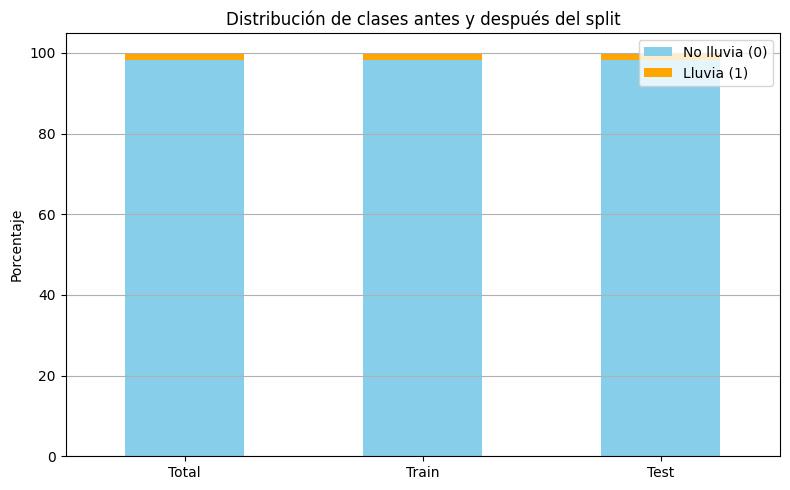

In [44]:
train_df, test_df = split_balanced(df, target='rain', test_size=0.3)
plot_class_balance(df, train_df, test_df, target='rain')


### 📉 Análisis de valores nulos

Se identifican columnas con valores ausentes. Como `LogisticRegression` y `RandomForest` no aceptan nulos, es necesario imputarlos antes de entrenar.



In [57]:
train_df.isna().sum()

time         0
temp         0
rhum     17505
prcp         0
wdir     37366
wspd     17604
pres     70324
rain         0
fecha        0
hora         0
day          0
month        0
year         0
dtype: int64

### 🔧 Imputación de valores nulos

Se rellenan los valores ausentes en `rhum`, `wdir`, `wspd`, `pres` usando la **media del conjunto de entrenamiento (`train_df`)**. Esta técnica previene la fuga de información desde el test hacia el modelo.


In [58]:
# Rellenar con la media de cada variable (usando solo train_df)
for col in ['rhum', 'wdir', 'wspd', 'pres']:
    media = train_df[col].mean()
    train_df[col].fillna(media, inplace=True)
    test_df[col].fillna(media, inplace=True)  # imputar con la misma media


C:\Users\alex_\AppData\Local\Temp\ipykernel_5304\1943298171.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(media, inplace=True)
C:\Users\alex_\AppData\Local\Temp\ipykernel_5304\1943298171.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

### 🧠 Entrenamiento del modelo

Se entrena el modelo de Regresión Logística y Random Forest usando los conjuntos previamente separados. Luego se evalúan con métricas clásicas (accuracy, F1, ROC, matriz de confusión).


C:\Users\alex_\AppData\Local\Temp\ipykernel_5304\1687122224.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(media, inplace=True)
C:\Users\alex_\AppData\Local\Temp\ipykernel_5304\1687122224.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

✔ Modelo Logistic Regression entrenado.
✔ Modelo Random Forest entrenado.
📈 Evaluación del modelo: Random Forest
Accuracy: 0.9887440487960696
F1 Score: 0.5547533092659447

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     64664
           1       0.79      0.43      0.55      1079

    accuracy                           0.99     65743
   macro avg       0.89      0.71      0.77     65743
weighted avg       0.99      0.99      0.99     65743



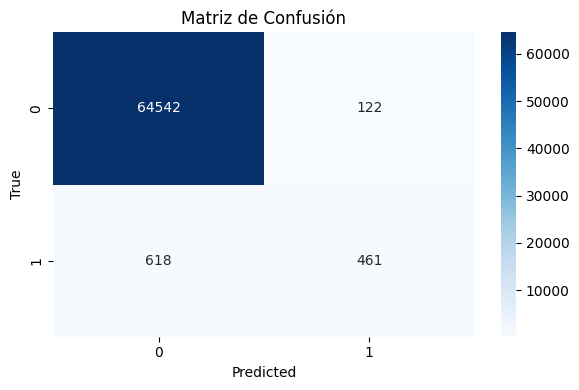

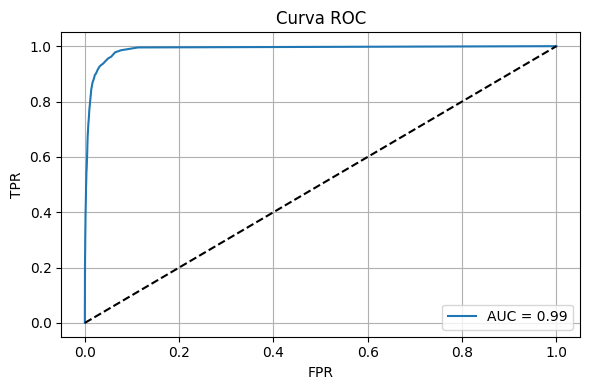

                Modelo  Accuracy  F1 Score
0  Logistic Regression  0.983359  0.019713
1        Random Forest  0.988744  0.554753


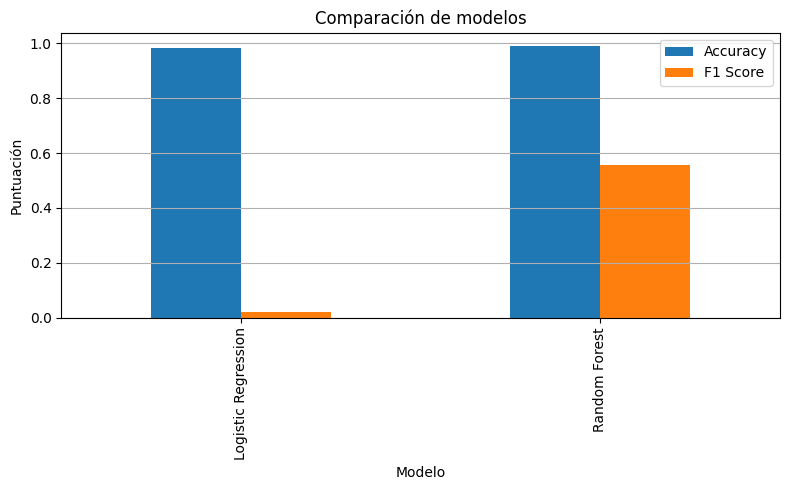

In [60]:
# Paso 1: split balanceado
train_df, test_df = split_balanced(df, target='rain', test_size=0.3)

for col in ['rhum', 'wdir', 'wspd', 'pres']:
    media = train_df[col].mean()
    train_df[col].fillna(media, inplace=True)
    test_df[col].fillna(media, inplace=True)  # imputar con la misma media

# Paso 2: definir variables
features = ['day', 'month', 'year', 'hora', 'rhum', 'wspd', 'pres', 'temp']
target = 'rain'

# Paso 3: modelado
model = Modeling(train_df, test_df, features, target)

model.train_logistic_regression()
model.train_random_forest()
model.evaluate('Random Forest')
model.compare_models()


### 📈 Evaluación dinámica según umbral (threshold)

Se analiza cómo varían las métricas (`Precision`, `Recall`, `F1-score`) al cambiar el umbral de decisión usado para predecir lluvia (`P(rain) > threshold`). Esto ayuda a ajustar el modelo según necesidades reales (más o menos sensible).


In [63]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_threshold_metrics(model, X_test, y_test, thresholds=np.arange(0.0, 1.01, 0.05)):
    """
    Grafica cómo varían las métricas Precision, Recall y F1-score para la clase 1
    en función del umbral de decisión.

    Args:
        model: Modelo entrenado con predict_proba.
        X_test: Conjunto de test.
        y_test: Valores reales.
        thresholds (array): Valores de umbral a probar.
    """
    precision_list = []
    recall_list = []
    f1_list = []

    # Probabilidades de clase 1
    probs = model.predict_proba(X_test)[:, 1]

    for threshold in thresholds:
        preds = (probs >= threshold).astype(int)
        precision = precision_score(y_test, preds, zero_division=0)
        recall = recall_score(y_test, preds, zero_division=0)
        f1 = f1_score(y_test, preds, zero_division=0)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision_list, label='Precision')
    plt.plot(thresholds, recall_list, label='Recall')
    plt.plot(thresholds, f1_list, label='F1-Score')
    plt.xlabel('Threshold')
    plt.ylabel('Métrica')
    plt.title('Evolución de métricas según el umbral')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



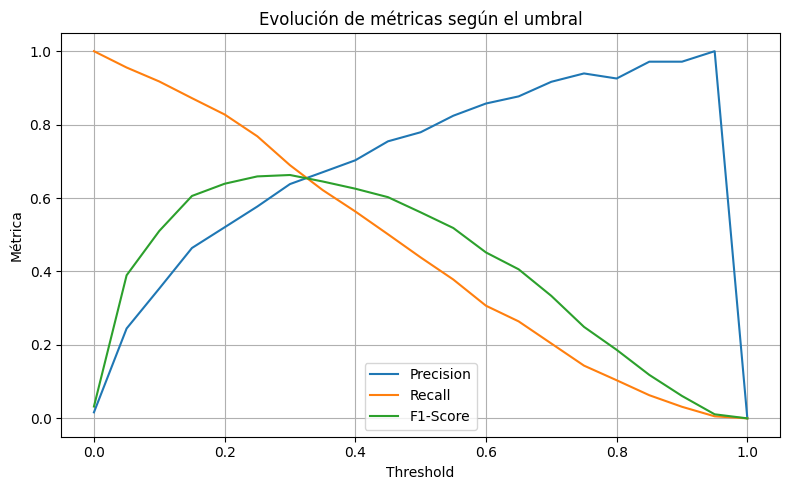

In [64]:
plot_threshold_metrics(model.models['Random Forest'], model.X_test, model.y_test)


### ✅ Evaluación final con threshold personalizado

Se aplica el umbral elegido (`0.3`) para mejorar la sensibilidad del modelo ante la clase minoritaria (`rain = 1`). Se muestran las métricas, matriz de confusión y AUC para validar la decisión.



In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

def evaluate_with_threshold(model, X_test, y_test, threshold=0.5):
    """
    Evalúa el modelo con un umbral de clasificación personalizado y muestra gráficos.

    Args:
        model: Modelo entrenado con predict_proba.
        X_test: Variables predictoras de test.
        y_test: Valores reales.
        threshold (float): Umbral para predecir clase 1.
    """
    # Probabilidades de clase 1
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)

    # Métricas
    cm = confusion_matrix(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    auc = roc_auc_score(y_test, probs)

    print(f"🔎 Evaluación con threshold = {threshold}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, preds))
    print(f"AUC: {auc:.3f}")

    # 🔷 Matriz de confusión (gráfico)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión (threshold = {threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return report


🔎 Evaluación con threshold = 0.3
Confusion Matrix:
[[64219   445]
 [  322   757]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     64664
           1       0.63      0.70      0.66      1079

    accuracy                           0.99     65743
   macro avg       0.81      0.85      0.83     65743
weighted avg       0.99      0.99      0.99     65743

AUC: 0.989


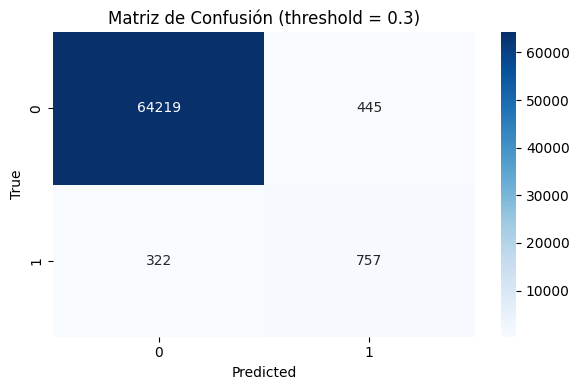

In [66]:
report = evaluate_with_threshold(
    model.models['Random Forest'],
    model.X_test,
    model.y_test,
    threshold=0.3
)


### 🔮 Predicción con un nuevo ejemplo

Se introduce un nuevo registro con condiciones meteorológicas reales y se predice la probabilidad de lluvia usando el modelo Random Forest y el threshold ajustado.  
Esta función (`predict_new`) simula el uso real del modelo en un sistema externo.



In [74]:
# Nuevo ejemplo: 14 de febrero de 2025, 15:00, 85% humedad, 7.2 km/h viento, 1012.5 hPa, 11.3 °C
nuevo_registro = {
    'day': 14,
    'month': 2,
    'year': 2025,
    'hora': 15,
    'rhum': 85.0,
    'wspd': 7.2,
    'pres': 1012.5,
    'temp': 11.3
}

# Predicción
pred, proba = predict_new(model.models['Random Forest'], features, nuevo_registro, threshold=0.3)

print(f"¿Lloverá? {'Sí ☔' if pred == 1 else 'No 🌤'}")
print(f"Probabilidad de lluvia: {proba:.2%}")



¿Lloverá? Sí ☔
Probabilidad de lluvia: 38.00%


## ✅ Conclusión

En este proyecto se ha desarrollado un modelo de clasificación binaria para predecir la probabilidad de lluvia en Bilbao utilizando variables meteorológicas horarias de los últimos 25 años. Se aplicaron técnicas de balanceo de clases, análisis exploratorio, imputación de valores ausentes, y ajuste de umbral de decisión para optimizar la sensibilidad del modelo.

El modelo final, basado en Random Forest y evaluado con un threshold personalizado (`0.3`), logra un excelente AUC (0.99) y un equilibrio razonable entre precisión y recall en la detección de lluvia. Esta metodología puede ser útil como base para un sistema de alertas tempranas o predicción meteorológica.

📌 **Palabras clave del proyecto**: clasificación binaria, balanceo de clases, umbral personalizado, imputación, métricas ajustadas, predicción de lluvia.

